### Data Quality Assessment

#### Expectations

To assess data quality, expectations for quality need to be defined and agreed with subject matter experts. 

With expectations set, these can be expressed as rules that data can be measured against. For example, a table needs to have the fields we are expecting, and of the right type; fields values may need to be unique, or may need to conform to a given domain of values. 

Whatever the expectations, they will require checking on a regular basis to ensure data quality is being maintained, or to identify where problems might be occurring. 

It would also be really handy to have some sort of documentation generated that we could keep along with our data to demonstrate what was assessed, how the data performed, and whether any additional rules might be needed.

The *great_expectations* library provides tools to assist.

To get started, and in a cloned environment, use pip to install:

``` shell
pip install great-expectations
```

To verify, using python in your cloned environment, run:

``` python
import great_expectations as gx
print(gx.__version__)
```
This returns the current version of great-expectations - 1.3.0 (as at 1 Janaury 2025)

The code for this example is taken from [Introduction to GX Core](https://docs.greatexpectations.io/docs/core/introduction/).

To get started, import the library and create a context (which acts as a container for the workspace you are going to build to do the data quality meauring thing)

In [136]:
import great_expectations as gx
context = gx.get_context()
# assert type(context).__name__ == "EphemeralDataContext"

##### Configuration

There is a lot of configuration that needs to be done to set up the context so that you can run your data against a set of rules.

The first thing is to set up references to the data. Pandas dataframes are a recognised source of data, as are SQL databases, or cloud-based systems. For this exercise, we'll just use a pandas dataframe to keep things simple. In the future it would be useful to pair this against data stored in our MS SQL databases (imagine this against IRIS, LAB, etc).

Anyway, as far as I can tell, the initial config is structured like this:
```
    context                                      Workspace
       |-- data_source                           Source system = Pandas, SQL, Cloud ...
              |-- data_asset                     Data container = Dataframe, Table, ....
                     |-- batch_definition        Defining where data is coming from and any filters if needed
 ```

 These things are all defined as a skeleton to start with, and then updated as needed. Boiler-plate code, in other words.

In [137]:
# This is all taken from the documentation

# SETUP FOR THE EXAMPLE:
data_source = context.data_sources.add_pandas(name="my_data_source")
data_asset = data_source.add_dataframe_asset(name="my_dataframe_data_asset")

# Retrieve the Data Asset
data_source_name = "my_data_source"
data_asset_name = "my_dataframe_data_asset"
data_asset = context.data_sources.get(data_source_name).get_asset(data_asset_name)

# Define the Batch Definition name
batch_definition_name = "my_batch_definition"

# Add a Batch Definition to the Data Asset
batch_definition = data_asset.add_batch_definition_whole_dataframe(
    batch_definition_name
)
assert batch_definition.name == batch_definition_name

Now we bring in pandas and create a dataframe, and create a variable called 'batch_parameters' that contains a dictionary of {"dataframe": dataframe}

In [138]:
# Now we actually bring in some data ... 

import pandas as pd

csv_path = "~/gx/MyEBirdData-83.csv"
dataframe = pd.read_csv(csv_path)

# ... and this can get added into the context above through "batch_parameters"
batch_parameters = {"dataframe": dataframe}

Next, we add the batch_parameters to the empty batch_definition object created previously. The data gets referenced in our context.

In [139]:
# Get the dataframe as a Batch
batch = batch_definition.get_batch(batch_parameters=batch_parameters)


##### Setting up expectations to validate

The next step is to build the data quality busines rules, or expectations, to be assessed. 

A lot of rules come prebuilt with the great-expectation library (see https://greatexpectations.io/expectations/). The available list is reproduced in the dataframe below.

In [140]:
csv_path = "~/gx/gx_expectation_list.csv"
rules = pd.read_csv(csv_path)
rules.sort_values(["Data quality issue","Expectation"])

,Expectation,Data quality issue
12,ExpectColumnProportionOfUniqueValuesToBeBetween,Cardinality
17,ExpectColumnUniqueValueCountToBeBetween,Cardinality
26,ExpectColumnValuesToBeUnique,Cardinality
37,ExpectCompoundColumnsToBeUnique,Cardinality
39,ExpectSelectColumnValuesToBeUniqueWithinRecord,Cardinality
10,ExpectColumnPairValuesToBeEqual,Data Integrity
38,ExpectMulticolumnSumToEqual,Data Integrity
3,ExpectColumnKLDivergenceToBeLessThan,Distribution
9,ExpectColumnPairValuesAToBeGreaterThanB,Distribution
14,ExpectColumnStdevToBeBetween,Distribution


To help build the rules, doing some data prep to populate the expectations later

In [141]:
# To help build the rules, doing some data prep to populate the expectations later
# Building dictionary of data types

# Getting data types to validate data columns
d={}
s = dataframe.dtypes

d = s.to_dict(into=d)
print(d)

# Tidying up dictionary values  to string equivalents, and replacing 'object' with 'str'
for key, value in d.items():
    if str(value)=='object':
        d[key]='str'
    else:
        d[key]=str(value)
#print(d)


{'Submission ID': dtype('O'), 'Common Name': dtype('O'), 'Scientific Name': dtype('O'), 'Taxonomic Order': dtype('int64'), 'Count': dtype('int64'), 'State/Province': dtype('O'), 'County': dtype('O'), 'Location ID': dtype('O'), 'Location': dtype('O'), 'Latitude': dtype('float64'), 'Longitude': dtype('float64'), 'Date': dtype('O'), 'Time': dtype('O'), 'Protocol': dtype('O'), 'Duration (Min)': dtype('float64'), 'All Obs Reported': dtype('int64'), 'Distance Traveled (km)': dtype('float64'), 'Area Covered (ha)': dtype('float64'), 'Number of Observers': dtype('int64'), 'Breeding Code': dtype('O'), 'Observation Details': dtype('O'), 'Checklist Comments': dtype('O'), 'ML Catalog Numbers': dtype('O')}


In [ ]:
# With the context ready, we can now create a series of data quality tests, 
# or expectations.
# Usually, there will be many tests to define, and these are grouped into a "suite"

# Setup increment number for expectation suite, validation definition, and checkpoint names
import uuid
label_number =str(uuid.uuid4())

# Create an Expectation Suite
suite_name = "suite-"+label_number
suite = gx.ExpectationSuite(name=suite_name)

# Add the Expectation Suite to the Data Context
suite = context.suites.add(suite)

# Create an Expectation to put into an Expectation Suite
# expectation = gx.expectations.ExpectColumnValuesToNotBeNull(column="passenger_count")
# SCHEMA CHECK
#   1. ExpectTableColumnsToMatchSet()
#   First verify the columns - all columns must exist. 
#   If any additional columns are found this will cause test to return False.
#   Set exact_match=False if additional columns are ok.
expectation = gx.expectations.ExpectTableColumnsToMatchSet(column_set=list(dataframe.columns),
                                                           exact_match=True)
# Add the previously created Expectation to the Expectation Suite
suite.add_expectation(expectation)

# SCHEMA CHECK
#   2.  ExpectTableColumnsToMatchOrderedList()
expectation = gx.expectations.ExpectTableColumnsToMatchOrderedList(column_list=list(dataframe.columns))
suite.add_expectation(expectation)

# SCHEMA CHECK
#   3. ExpectTableColumnCountToEqual
expectation = gx.expectations.ExpectTableColumnCountToEqual(value=len(dataframe.columns))
suite.add_expectation(expectation)

# SCHEMA CHECK
#   4. ExpectColumnValuesToBeOfType
#   This needs to be specified for each column.

for key, value in d.items():
    expectation = gx.expectations.ExpectColumnValuesToBeOfType(column=key, type_=value)
    suite.add_expectation(expectation)
                                                     
# Add another Expectation to the Expectation Suite.
suite.add_expectation(
    gx.expectations.ExpectColumnValuesToNotBeNull(column="Count")
)

# Update the configuration of an Expectation, then push the changes to the Expectation Suite
#expectation.column = "pickup_location_id"
#expectation.save()

# Retrieve an Expectation Suite from the Data Context
existing_suite_name = (
    suite_name  # replace this with the name of your Expectation Suite
)
suite = context.suites.get(name=existing_suite_name)


In [143]:
validation_definition_name = "vdef-"+label_number
validation_definition = gx.ValidationDefinition(
    data=batch_definition, suite=suite, name=validation_definition_name
)
validation_definition = context.validation_definitions.add(validation_definition)

In [144]:

from great_expectations.checkpoint import (
    UpdateDataDocsAction,
)


# Create a list of one or more Validation Definitions for the Checkpoint to run
validation_definitions = [
    context.validation_definitions.get(validation_definition_name)
]

# Create a list of Actions for the Checkpoint to perform
action_list = [
    # This Action updates the Data Docs static website with the Validation
    #   Results after the Checkpoint is run.
    UpdateDataDocsAction(
        name="update_all_data_docs",
    ),
]

# Create the Checkpoint
checkpoint_name = "checkpoint-"+label_number
checkpoint = gx.Checkpoint(
    name=checkpoint_name,
    validation_definitions=validation_definitions,
    actions=action_list,
    result_format={"result_format": "COMPLETE"},
)

# Save the Checkpoint to the Data Context
context.checkpoints.add(checkpoint)


Checkpoint(name='checkpoint-bbf6c121-b2a7-4862-9993-d37a1a63a026', validation_definitions=[ValidationDefinition(name='vdef-bbf6c121-b2a7-4862-9993-d37a1a63a026', data=BatchDefinition(id=UUID('f228709f-4fb5-4187-ba49-519f18e10820'), name='my_batch_definition', partitioner=None), suite={
  "name": "suite-bbf6c121-b2a7-4862-9993-d37a1a63a026",
  "id": "8cda8384-be75-4ad6-acb7-e4e06b15edd4",
  "expectations": [
    {
      "type": "expect_table_columns_to_match_set",
      "kwargs": {
        "column_set": [
          "Submission ID",
          "Common Name",
          "Scientific Name",
          "Taxonomic Order",
          "Count",
          "State/Province",
          "County",
          "Location ID",
          "Location",
          "Latitude",
          "Longitude",
          "Date",
          "Time",
          "Protocol",
          "Duration (Min)",
          "All Obs Reported",
          "Distance Traveled (km)",
          "Area Covered (ha)",
          "Number of Observers",
     

In [145]:
# Run the checkpoint

checkpoint = context.checkpoints.get(checkpoint_name)

#batch_parameters = {"month": "01", "year": "2019"}

#expectation_parameters = {
#    "expect_fare_max_to_be_above": 5.00,
#    "expect_fare_max_to_be_below": 1000.00,
#}

validation_results = checkpoint.run(
    batch_parameters=batch_parameters
)

Calculating Metrics:   0%|          | 0/110 [00:00<?, ?it/s]

In [146]:
context.build_data_docs()
context.open_data_docs()

### Using the expectation suite to validate against another dataset

This is where the value of setting up everything above comes into its own

In [147]:

csv_path = "~/gx/MyEBirdData-100.csv"
dataframe = pandas.read_csv(csv_path)

# ... and this can get added into the context above through "batch_parameters"
batch_parameters = {"dataframe": dataframe}
# Get the dataframe as a Batch
#batch = batch_definition.get_batch(batch_parameters=batch_parameters)

# Adding another checkpoint
validation_results = checkpoint.run(
    batch_parameters=batch_parameters
)


Calculating Metrics:   0%|          | 0/89 [00:00<?, ?it/s]

#### Appendix

##### Common Data Quality Dimensions

Citation: 

*Dama International. 2024. DAMA-DMBOK: Data Management Body of Knowledge (2nd Edition, Revised). Technics Publications, LLC, Basking Ridge, NJ, USA.*

**Note: other definitions of data quality dimensions exist. What's listed below is a set where there is general agreement.**

Table 29 from DAMA-DMBOK


|Dimension of Quality|Description|
|---|---|
|Validity|Validity refers to whether data values are consistent within a defined domain of values|
|Completeness|Completeness refers to whether all the required data is present. For example, are all the mandatory components of an address populated?. Completeness can be measured at the column, record, or data set level.|
|Consistency|Consistency is ensuring that data values are coded using the same approach, assessment and valuation criteria. Consistency is between two different data items, potentially within a data set and between data sets, and across time. Consistency may be defined between one set of data element values and another data element set within the same record (record-level consistency), between one set of data element values and another data element set in differet records (cross-record consistency), or between one set of data element values and the same data element set within the same record at different points in time (temporal consistency). Consistency can also be used  to refer to consistency of format. Take care not to confuse consistency with accuracy or correctness.|
|Integrity|Integrity refers to the lack of incoherent values and broken relationships in data. Data sets without integrity are seen as corrupted or have data loss. Data sets without referential integrity have 'orphans' - invalid reference keys, or 'duplicates' - identical rows which may negatively affect aggregation functions.|
|Timeliness|Data Timeliness refers to the time that data needs to become accessible to a user after its capture or update. Timeliness is the expectation and actual delay before the data becomes available.|
|Currency|Currency is the date that the data set was last updated relative to now and the likelihood that it is still correct. Different data sets will have diefferent currency expectations from relatively static data to highly volatile data. Static data remains current for a long period. Volatile data remains current for a relatively short period.|
|Reasonableness|Reasonableness asks whether a data pattern meets expectations. For example, whether a distribution of sales in a geographic area makes sense based on what is known about the customers in that area. For example, based on previous customer logins at 5pm, are today's customer logins to our systems out of the ordinary?|
|Uniqueness / Deduplication|Uniqueness states that no real-world entity exists more than once within the data set. Asserting uniqueness of the entities within a data set implies that each row relate to each entity in the real world, and only that specific entity.|
|Accuracy|Accuracy refers to the degree that data correctly represents 'real-life' entities. Accuracy is difficult to measure unless an organisation can reproduce data collection or manually confirm accuracy of records. Most measures of accuracy use the other dimensions to imply accuracy.|


##### Data Quality Business Rules

In management of data quality, one of the goals is to *define and implement processes to measure, monitor, and report on data quality levels*.

*Business Rules* describe how data should exist in order to be useful and usable within an organisation. *Data Quality Business Rules* are aligned with data quality dimensions and are used to describe Data Quality Requirements. For example, business rules for managing state/province names could be:

- **Validity** - all state/province names must be a value from the reference table stored in the Metadata repository.
- **Completeness** - All addresses must have a state/province if the country is divided into states/provinces. Otherwise, they should not have a state/province value.
- **Integrity** - All state/province names must have a value that is linked to the country name of the address.
- **Currency** - The reference values will be periodically updated and the current addresses will need to be brought up to date with the current names. This will keep all the state/province names current with the latest reference values.
  
Some common business rule types (aligned with most common dimensions) are:

- **Validity**: can be implemented through rules such as:
    + **Format compliance rules**: One or more patterns specify values assigned to a data element, such as standards for formatting telephone numbers.
    + **Value domain membership**: Specify that a data element's assigned value is included in those enumerated in a defined data value domain, such as 2-character United States Postal Codes for a STATE field
    + **Range conformance**: A data element assigned value must be within a defined numeric, lexicographic, or time range, such as greater than 0 and less than 100 for a numeric range.
    + **Mapping conformance**: Indicating that the value assigned to a data element must correspond to one selected from a value-domain that maps to other equivalent corresponding value domain(s). The STATE data domain again provides a good example, since State values may be represented using different value domains (USPS Postal Codes, FIPS 2-digit codes, full names), and these types of rules validate that 'AL' and '01' both map to 'Alabama'.
  
- **Completeness or Value presence and record completeness**: Rules defining the conditions under which missing values are acceptable or unacceptable.

- **Consistency rules**: Conditional assertions that refer to maintaining a relationship between two (or more) data elements based on the actual values of those data elements. For example, address validation where postal codes correspond to particular States or Provinces.

- **Consistency may also drive Definitional conformance rules**: Confirm that the same understanding of data definitions is implemented and used properly in processes across the organisation. Confirmation includes algorithmic agreement on calculated fields, including any time or local constraints, and rollup and status interdependence rules.

- **Integrity rules**: Rules expressed as assertions to maintain a relationship between two (or more) data elements based on the actual values of those data elements. For example, address validation where postal codes correspond to particular States or Provinces. (How does this differ from the *Consistency rule*. I think the integrity rule needs be updated based on the description of Data Quality Dimension - Rules to determine if orphaned records exist between two or more data sets. Duplicates are dealth with under uniqueness.

- **Timeliness validation**: Rules that indicate the characteristics associated with expectations for accessibility and availability of data. Timeliness rules often break down a process into a series of stage where timeliness is monitored thrugh the cycle to ensure the dependent data is also achieving the timeliness requirement.

- **Uniqueness** Rules that specify which entities must have a unique representation and whether one and only one record exists for each represented real world object. In Data Quality checks, we may habe rules that go beyond simple tests to assess the likelihood of a duplicate value. For example, it may search for people living at the same address that are behaving in a cooperative fashion (that leads us to believe they may be the same person).

- **Reasonableness**: May be implemented through aggregating functions applied to sets of data instances. Examples of aggregation checks include validating reasonableness by a:
    + *relative* measure. For example, today's record count in a file is assessed by keeping statistics over time to generate an understanding of "normality" which is used to assess reasonableness in this particular instance.
    + *absolute* measure. For example, validating the reasonableness of an aveerage amount calculated from a set of transactions by a set of fixed thresholds that the values must fall within.

  - These concepts of relative and absolute measures for determining reasonability can be used on any data types, such as an absolute date range (fixed period of time), or a relative date range (e.g. to today), computed totals, record counts, etc. 

- **Accuracy verification**: Compare a data value against a corresponding value in a system of record or other verified source to verify that the values match.

##### Data Quality Improvement Lifecycle

Most approaches to improving Data Quality are based on the techniques of quality improvement in the manufacture of physical products. In this paradigm data is understood as a product of a set of processes. At its simplest, a process is defined as a series of steps that turns inputs into outputs. A process that creates data may consist of one-step (data collection) or many steps: data collection, integration into a data warehouse, aggregation into a data mart, etc. At any step data can be negatively affected. It can be collected incorrectly, dropped or duplicated between systems, aligned or aggregated incorrectly , etc. Improving Data Quality requires the ability to assess the relationship between inputs and outputs in order to ensure that inputs meet the requirements of the process and that outputs conform to expectations. Since outputs from one process become inputs to other processes, requirements must be defined along the whole data chain.

A general approach to Data Quality improvement, shown in the figure below, is a version of the Shewhart / Deming cycle. Based on the scientific method, the Shewhart / Deming cycle is a problem-solving model known as 'plan-do-check-act'. Improvement comes through a defined set of steps. The condition of the data must be measured against standards and, if it does not meet standards, root cause(s) of the discrepancy from standards must be identified and remediated. Root causes may be found in any of the steps in the process, technical or non-technical. Once remediated, data should be monitored to ensure that it continues to meet requirements.

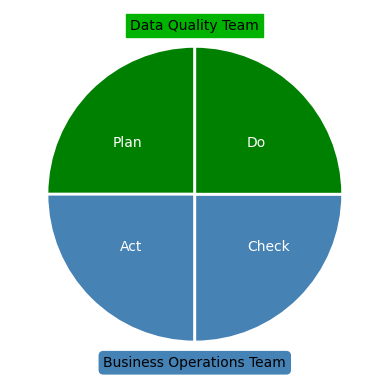

In [193]:
def deming():
        # code to generate Shewhart / Deming diagram
        #%pip install matplotlib
        import matplotlib.pyplot as plt

        # Create a dataframe with the data

        data = {'Deming': ['Plan', 'Act', 'Check', 'Do'],

                'Stage': [1, 1, 1, 1]}

        df = pd.DataFrame(data)

        # Define custom colors

        colors = ['green', 'steelblue', 'steelblue', 'green']

        # Plot the pie chart with custom colors

        plt.pie(df['Stage'], labels=df['Deming'], labeldistance=.5, colors=colors, startangle=90, 
                wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' }, textprops={'color':'white'})

        plt.text(0., -1.14, "Business Operations Team", size=10, rotation=0.,
                ha="center", va="center", wrap=True,
                bbox={'boxstyle':"round",
                        'ec':(0.27, 0.51, 0.71),
                        'fc':(0.27, 0.51, 0.71),
                        }
                )

        plt.text(0., 1.14, "Data Quality Team", size=10, rotation=0.,
                ha="center", va="center", wrap=True,
                bbox={'boxstyle':"square",
                        'ec':(0., 0.7, 0.),
                        'fc':(0., 0.7, 0.),
                        }
                )

        plt.show() 
deming()

For a given data set, a Data Quality Management cycle begins by the Data Quality team identifying the data that does not meet data consumers' requirements and data issues that are obstacles to the achievement of business objectives. Data needs to be assessed against key dimensions of quality and known business requirements. Root causes of issues will need to be identified so that stakeholders can understand the costs of remediation and the risks of not remediating the issues. This work is often done in conjunction with the relevant business operational teams, Data Stewards and other stakeholders.

In the *Plan* stage, the Data Quality team assesses the scope, impact, and priority of known issues and evaluates alternatives to address them. This plan should be based on a solid foundation of analysis of root causes of issues. From knowledge of the causes and the impacts of the issues, cost / benefit can be understood, priority can be determined, and a basic plan can be formulated to address them.

In the *Do* stage, the Data Quality team leads efforts to address the root causes of issues and plan for ongoing monitoring of data. For root causes that are based on non-technical processes, the Data Quality team can work with process owners to implement changes. For root causes that require technical changes, the Data Quality team should work with technical teams to ensure that requirements are implemented correctly and that technical changes do not introduce errors.

The *Check* stage involves actively monitoring the quality of data as measured against requirements. This is largely the responsibility of the business operations teams that manage the data on a daily basis. As long as data meets defined thresholds for quality, additional actions from the Data Quality team are not requiered. The processes will be considered under control and meeting business requirements. However, if the the data falls below acceptable quality thresholds, then additional actions must be taken to bring it up to acceptable levels.

The *Act* stage is for activities to address and resolve emerging Data Quality issues. This activity is usually also performed by the business operational team.  The cycle restarts as the Data Quality team identifies new issues. Continuous improvement is achieved by  starting a new cycle. New cycles begin as:

- Existing measurements fall below thresholds
- New data sets come under investigation
- New Data Quality requirements emerge for existing data sets
- Business rules, standards, or expectations change.

The DMBOK Data Quality activities are mapped to the diagram above in the lists below.


**Plan (Data Quality team)**

1. Define High Quality Data
2. Define a Data Quality Policy
3. Define Scope of Initial Assessment
4. Perform initial Data Quality Assessment
5. Identify & Prioritise Improvements
6. Define Goals for Data Quality Improvement

**Do (Data Quality team)**

7. Develop and Deploy Data Quality Operations
   
- Develop Data Quality Operational Procedures

**Check (Operations)**

8. Develop and Deploy Data Quality Operations
   
- Correct Data Quality Defects
- Measure and Monitor Data Quality
- Report on Data Quality levels and findings.

**Act (Operations)**

9. Correct Data Quality Defects


This mapping enables understanding Data Quality using a manufacturing mindset.


